In [ ]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [ ]:
def construct_N_matrix(intensity: int):
    N = [[0 if i == j else (i % 3) * intensity for i in range(0, 20)] for j in range(0, 20)]
    return N

In [ ]:
def construct_handcrafted_graph(CAPACITY: int):
    G = nx.null_graph()
    G.add_edge(0, 1, a = 0, c = CAPACITY)
    G.add_edge(0, 19, a = 0, c = CAPACITY)
    G.add_edge(1, 2, a = 0, c = CAPACITY)
    G.add_edge(2, 3, a = 0, c = CAPACITY)
    G.add_edge(3, 4, a = 0, c = CAPACITY)
    G.add_edge(3, 17, a = 0, c = CAPACITY)
    G.add_edge(4, 5, a = 0, c = CAPACITY)
    G.add_edge(4, 19, a = 0, c = CAPACITY)
    G.add_edge(5, 6, a = 0, c = CAPACITY)
    G.add_edge(5, 14, a = 0, c = CAPACITY)
    G.add_edge(6, 7, a = 0, c = CAPACITY)
    G.add_edge(7, 8, a = 0, c = CAPACITY)
    G.add_edge(7, 12, a = 0, c = CAPACITY)
    G.add_edge(8, 9, a = 0, c = CAPACITY)
    G.add_edge(9, 10, a = 0, c = CAPACITY)
    G.add_edge(9, 12, a = 0, c = CAPACITY)
    G.add_edge(10, 11, a = 0, c = CAPACITY)
    G.add_edge(11, 12, a = 0, c = CAPACITY)
    G.add_edge(12, 13, a = 0, c = CAPACITY)
    G.add_edge(12, 19, a = 0, c = CAPACITY)
    G.add_edge(13, 19, a = 0, c = CAPACITY)
    G.add_edge(14, 15, a = 0, c = CAPACITY)
    G.add_edge(15, 16, a = 0, c = CAPACITY)
    G.add_edge(15, 19, a = 0, c = CAPACITY)
    G.add_edge(16, 17, a = 0, c = CAPACITY)
    G.add_edge(16, 18, a = 0, c = CAPACITY)
    G.add_edge(17, 18, a = 0, c = CAPACITY)
    return G

In [ ]:
def reset_flow_func(G: nx.Graph):
    for (u,v) in G.edges:
        edge = G[u][v]
        edge["a"] = 0

In [ ]:
def set_capacity(G: nx.Graph, capacity: int):
    for (u,v) in G.edges:
        edge = G[u][v]
        edge["c"] = capacity

In [ ]:
def simulate_flow(G: nx.Graph, N: List[List[int]]):
    reset_flow_func(G)
    for j in range(len(N)):
        for i in range(len(N[j])):
            # print("Going from " + str(i) + " to " + str(j))
            path = nx.shortest_path(G,i,j)
            if len(path) > 1:
                # print(path)
                for e in range(len(path) - 1):
                    G[path[e]][path[e + 1]]["a"] += N[path[e]][path[e+1]]

In [60]:
cached_pos = None

def draw(graph: nx.Graph):
    global cached_pos
    if cached_pos is None:
        cached_pos = nx.spring_layout(graph, iterations=1000, seed=10)
    pos = cached_pos
    nx.draw_networkx(graph, pos, node_color='#ab4b44', edge_color='white')
    # edge_labels = nx.get_edge_attributes(graph,'a')
    # nx.draw_networkx_edge_labels(graph, pos, edge_labels = edge_labels, font_size=6)
    nx.draw_networkx_labels(graph, pos)
    plt.savefig('graph2.png', transparent=True)
    plt.show()

In [ ]:
def latency(graph: nx.Graph, N: List[List[int]], m: int):
    G = sum(sum(N,[]))
    s = sum(data['a'] / (data['c'] / m - data['a']) for (_,_,data) in graph.edges(data = True))
    return s / G

In [ ]:
def experiment(G: nx.Graph, N: List[List[int]], probability: float, m: int):
    T = G.copy()
    
    removed = False
    # remove random edges
    for (u,v) in T.edges:
        p = random.random()
        if p > probability:
            removed = True
            T.remove_edge(u,v)

    if not nx.is_connected(T):
        # draw(T)
        return False

    # check if the network is not overloaded
    simulate_flow(T, N)
    for (u,v,data) in T.edges(data = True):
        if data['a'] * 8 * 1500 >= data['c']:
            return False
    return latency(T, N, m)

In [ ]:
# parameters
MAX_PROPAGATION = 0.3#s
CAPACITY = 1_000_000_000 #Gb/s
AVG_BITS_PER_PACKET = 12_000
INTENSITY = 1000
PROBABILITY = 0.995

N = construct_N_matrix(INTENSITY)
T = construct_handcrafted_graph(CAPACITY)

In [ ]:
# base test
# draw(T)
# successes = 0
# for i in range(100000):
#     result = experiment(T, N, PROBABILITY, AVG_BITS_PER_PACKET)
#     if result is not False:
#         successes += 1

# print(successes)

In [ ]:
graph_data = []

In [ ]:
for intensity in range(100, 3000, 50):
    N = construct_N_matrix(intensity)
    successes = 0
    for i in range(5000):
        result = experiment(T, N, PROBABILITY, AVG_BITS_PER_PACKET)
        if result is not False:
            successes += 1
    print(successes / 5000)
    graph_data.append((intensity, successes / 5000))

In [ ]:
print(graph_data)

x_values = [point[0] for point in graph_data]
y_values = [point[1] for point in graph_data]

plt.style.use('dark_background')
plt.plot(x_values, y_values)

plt.xlabel('Intensity')
plt.ylabel('Niezawodność')

plt.title('Zwiększanie natężenia')

plt.savefig('intensity.png', transparent=True)
plt.show()

In [ ]:
graph_data_capacity = []

In [ ]:
for factor in np.arange(0.6, 1.4, 0.05):
    T = construct_handcrafted_graph(factor * CAPACITY)
    successes = 0
    for i in range(5000):
        result = experiment(T, N, PROBABILITY, AVG_BITS_PER_PACKET)
        if result is not False:
            successes += 1
    print(successes / 5000)
    graph_data_capacity.append((factor, successes / 5000))

In [ ]:
print(graph_data_capacity)

x_values = [point[0] for point in graph_data_capacity]
y_values = [point[1] for point in graph_data_capacity]

plt.style.use('dark_background')
plt.plot(x_values, y_values)

plt.xlabel('Współczynnik')
plt.ylabel('Niezawodność')

plt.title('Zwiększanie przepustowości')

plt.savefig('capacity.png', transparent=True)
plt.show()

In [ ]:
graph_data_edges = []

In [ ]:
T = construct_handcrafted_graph(CAPACITY)
for additions in range(1, 20):
    while True:
        new_edges = random.sample(range(0,20), 2)
        u = new_edges[0]
        v = new_edges[1]
        if not T.has_edge(u, v):
            print("new edge: " + str(u) + ", " + str(v))
            T.add_edge(u, v, a = 0, c = CAPACITY)
            break
    successes = 0
    for i in range(5000):
        result = experiment(T, N, PROBABILITY, AVG_BITS_PER_PACKET)
        if result is not False:
            successes += 1
    print(successes / 5000)
    graph_data_edges.append((additions, successes / 5000))

[(1, 0.9318), (2, 0.9662), (3, 0.9676), (4, 0.974), (5, 0.976), (6, 0.9852), (7, 0.9936), (8, 1.0), (9, 0.9998), (10, 0.9994), (11, 1.0), (12, 1.0), (13, 1.0)]


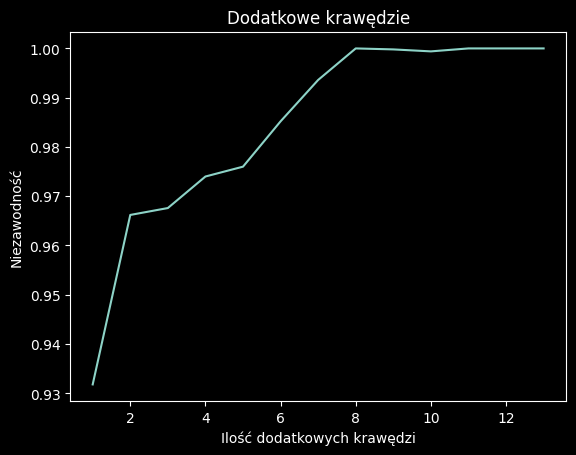

In [56]:
print(graph_data_edges)

x_values = [point[0] for point in graph_data_edges]
y_values = [point[1] for point in graph_data_edges]

plt.style.use('dark_background')
plt.plot(x_values, y_values)

plt.xlabel('Ilość dodatkowych krawędzi')
plt.ylabel('Niezawodność')

plt.title('Dodatkowe krawędzie')

plt.savefig('edges.png', transparent=True)
plt.show()

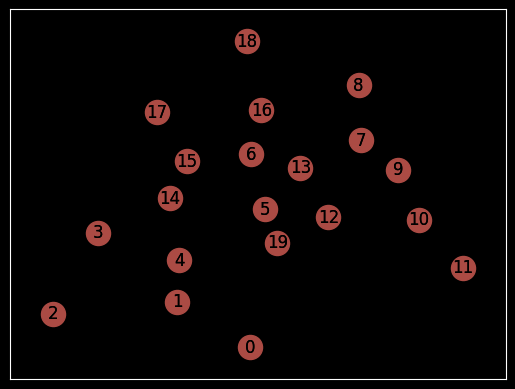

In [61]:
draw(T)